In [1]:
#ここのみいじるようなハイパラにする
#データサイズは2000行以内、それ以上はメモリを確認(環境gpu:rtx3090-24265MiB) 
download_name = "test_data" #testtextがテストデータ, fineに自分好みに変化可能(ファイル名は特に指定なし)
model_name = "tapt512_60K/" #学習済みモデル(事前学習,単語予測に使用)
RE_MODEL_NAME = "model_tapt_epo100_b128_len128/" #学習済みモデル(分類ファインチューニングモデル)
repeat_times = 3 #繰り返す回数、合計試行回数はプラス1

In [2]:
%cd data

/mnt/data1/home/yoshida/my_research/data


In [3]:
#!pip install --upgrade torchtext==0.9.0

In [4]:
#!pip install -U torch torchtext torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
# CUDA 11.3
#!pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113

In [5]:
!nvidia-smi

Mon Mar 27 17:41:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
| 42%   50C    P2   110W / 350W |   6219MiB / 24260MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
#一連の流れで実行するためのファイル

In [7]:
#pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

In [8]:
import random
import glob
from tqdm import tqdm

import torchtext
import torch
import numpy as np
from torch.utils.data import DataLoader
from transformers import BertJapaneseTokenizer, BertForSequenceClassification, BertForMaskedLM
#from pytorch_lightning.callbacks import ModelCheckpoint
import sys
import pandas as pd
#import pytorch_lightning as pl

import bert_score
# hide the loading messages
import logging

import MeCab
import subprocess
from IPython.display import HTML
#import torchvision
from func_ex import *
import transformers
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams

transformers.tokenization_utils.logger.setLevel(logging.ERROR)
transformers.configuration_utils.logger.setLevel(logging.ERROR)
transformers.modeling_utils.logger.setLevel(logging.ERROR)

In [9]:
def __main__():
    #モデルの選択
    tokenizer = BertJapaneseTokenizer.from_pretrained(model_name)
    bert_sc = BertForSequenceClassification.from_pretrained(RE_MODEL_NAME, num_labels=3, output_attentions=True) #学習済みモデルを用いた分類、num_labelで分類する種類の数
    bert_sc = bert_sc.cuda() #gpuに乗せて高速化させるための関数
    bert_mlm = BertForMaskedLM.from_pretrained(model_name,output_attentions=True)
    bert_mlm = bert_mlm.cuda()
    
    print("cleaning text...")
    df = makeclean_csv(download_name)
    #攻撃的かどうか判別したい文章をロード後判別する(ファイル名： download_name,2000文章まで、長さ128文節まで)
    print("load_data...")
    df = labeling_flaming(download_name, bert_sc, tokenizer) #judge_flaming.csvに保存される
    #攻撃的文章を変換処理する
    print("execute change flaming words...")
    df2 = flaming_to_safety(tokenizer,bert_mlm,bert_sc,3,0,attention_process = True) #bert_textlistに保存
    #print(df2)
    if df2.empty is True:
        print("No BERTscore")
    else:
        #BERTscoreを計算し、保存する(model_result.csv)
        print("show BERTsore...")
        df3 = Score_all(df2,1)
        #print(df3)
    
    #####繰り返し処理#####
    for num in range(repeat_times):
        if df3.empty is not True:
            print("re_load_data...")
            safety = df3.take([1],axis=1) #変換後の文章
            origin = df3.take([0],axis=1) #元の文章
            text_list = []
            for text in origin.iloc[:,0]:  ##.iloc[:,[0]]でラベルごと縦の列を取得可能,[]なしでラベルを除く(文章のみ)
                text_list.append(text)
            re_df, flaming_idx = labeling_flaming_df(safety,bert_sc,tokenizer)#変換後の文章をもう一度通す
            origin_flaming = [] 
            #攻撃的と判断された元の文章を抽出
            for idx in flaming_idx:
                origin_flaming.append(text_list[idx])
            #再度攻撃的と判断した文章の訂正
            re_df_safety = flaming_to_safety(tokenizer,bert_mlm, bert_sc,3,num+1,attention_process = True)
            #####ここに安全な文章(origin_flaming)とre_df_safety内のsafetyを抜き出したdfを作成#####
            safety_text = []
            for text in re_df_safety.iloc[:,1]:  ##.iloc[:,[0]]でラベルごと縦の列を取得可能,[]なしでラベルを除く(文章のみ)
                safety_text.append(text)
            re_df = pd.DataFrame({"flaming_text":origin_flaming, "safety_text": safety_text})
            ####作成したdfをBERTscore_show_dfに通す#####
            df3 = Score_all(re_df,num+2)
            #最終的にできたものがその回数ごとに保存される(model_result○.csv)
    
    print("finish!")

cleaning text...
                                                  text  tag
0    衆院選、小選挙区に809人が立候補予定朝日集計(朝日新聞デジタル)||自民党、維新の会、公明...  0.0
1    速報『b国に4km級のパンダ獣人が襲来!巨大生物たちは街の上で兜合わせを楽しみ、行為に巻き込...  0.0
2    (笑)河村市長って「南京大虐殺など無かった」、「表現の不自由展など許さん」等々、正真正銘の日...  1.0
3                                       バッハを亀甲縛りしましょう!  0.0
4        tlで大人のチュウ勃発️️️幼児退行、絶対的支配、淫靡の爛れたtl、どうなっちゃうの️️️  2.0
..                                                 ...  ...
395  見透かされてるんだよ…|老ぼれにとっては何もかも政治利用だが|性悪な人間故うまく行くことはな...  1.0
396                 そもそも一般人の助言を聞く、保守言論人や保守系政治家ってヤバいよな。  1.0
397                                      君は淫乱オナペット(適当)  0.0
398                                鉄オタは新左翼と同じくらい内ゲバが好き  1.0
399                                 左翼は頭いかれたやつしかおらんのか?  1.0

[400 rows x 2 columns]
load_data...


0it [00:00, ?it/s]

execute change flaming words...


96it [00:23,  3.98it/s]

Error NER
Error NER


175it [00:43,  3.99it/s]


show BERTsore...
senBERTscore


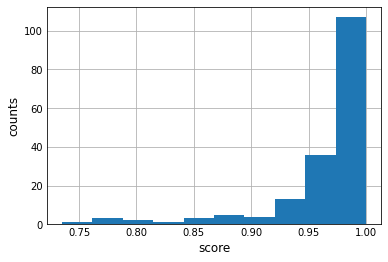

avarage score:  0.965854574155596


/usr/local/lib/python3.8/dist-packages/nltk-3.5-py3.8.egg/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.8/dist-packages/nltk-3.5-py3.8.egg/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Bleuscore


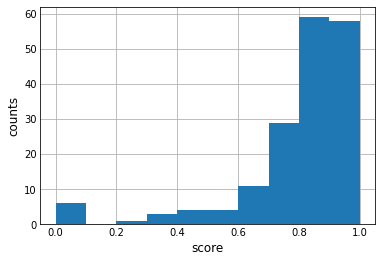

avarage score:  0.7950552909243741
calculating scores...
computing bert embedding.


  0%|          | 0/6 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/3 [00:00<?, ?it/s]

done in 0.54 seconds, 324.51 sentences/sec
F1score


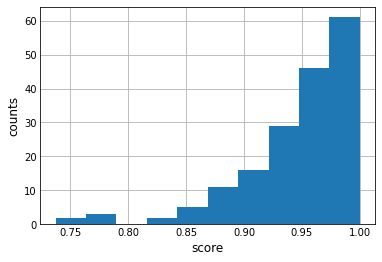

avarage score:  0.946099227155958
re_load_data...


87it [00:20,  3.91it/s]

Error NER
Error NER


165it [00:40,  4.08it/s]


senBERTscore


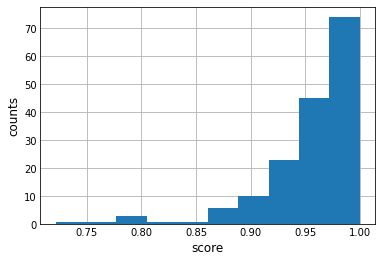

avarage score:  0.9536665650772104


/usr/local/lib/python3.8/dist-packages/nltk-3.5-py3.8.egg/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Bleuscore


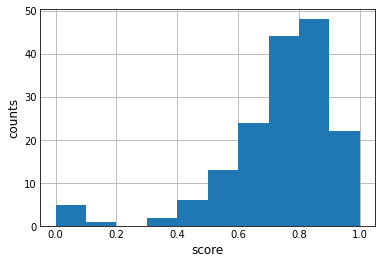

avarage score:  0.7336992569276567
calculating scores...
computing bert embedding.


  0%|          | 0/6 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/3 [00:00<?, ?it/s]

done in 0.51 seconds, 320.57 sentences/sec
F1score


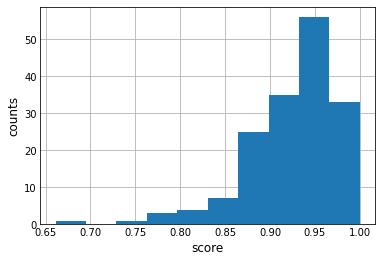

avarage score:  0.9243874188625452
re_load_data...


87it [00:18,  4.17it/s]

Error NER
Error NER


161it [00:37,  4.35it/s]


senBERTscore


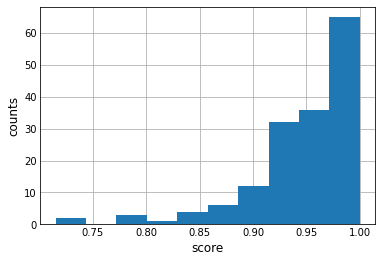

avarage score:  0.9461614464007201
Bleuscore


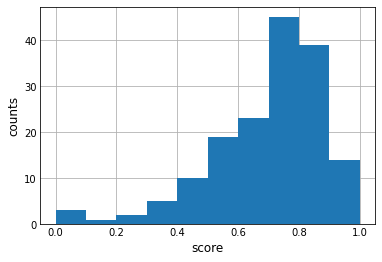

avarage score:  0.7036544231628158
calculating scores...
computing bert embedding.


  0%|          | 0/5 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/3 [00:00<?, ?it/s]

done in 0.49 seconds, 327.63 sentences/sec
F1score


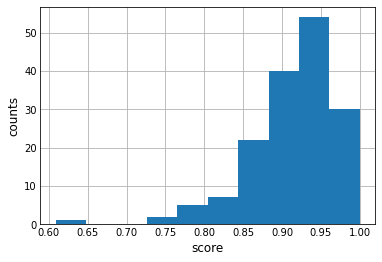

avarage score:  0.9136398105147463
re_load_data...


86it [00:20,  3.98it/s]

Error NER
Error NER


159it [00:38,  4.09it/s]


senBERTscore


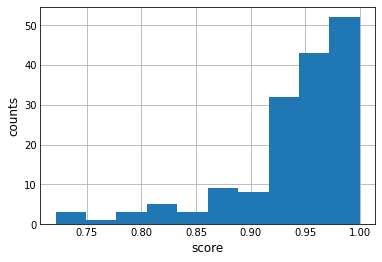

avarage score:  0.9390365929936673
Bleuscore


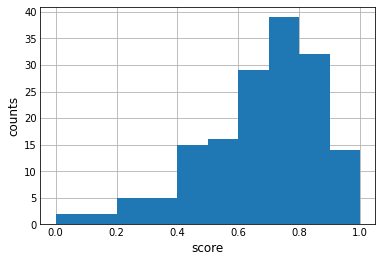

avarage score:  0.6803049510378948
calculating scores...
computing bert embedding.


  0%|          | 0/5 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/3 [00:00<?, ?it/s]

done in 0.48 seconds, 328.13 sentences/sec
F1score


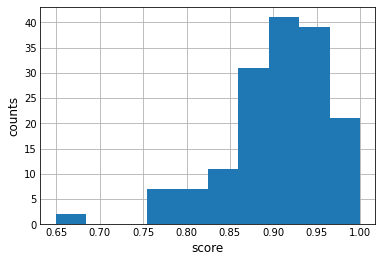

avarage score:  0.9047700391625458
finish!


In [10]:
if __name__ == __main__():
    main()

In [11]:
#このコードは危険単語の周辺単語もマスクし、ループ回数ごとに1,2,3,1,2,3,...のように上位○位抽出する箇所をずらしている。
#そのため結果に大きく変動が生じるため、結果に相違が出るだろう。
#もし変更したい場合はpredict_one_after_anotherに有る部分を変更することで以上の処理を元に戻すことができる。
#GoodLuck
#Author Motonobu Yoshida